In [ ]:
import pandas as pd
import geopandas as gpd
import folium
import numpy as np
import matplotlib.pyplot as plt
from folium.plugins import HeatMap

# Load fire incidents dataset
file_path = "/content/incidents-clean.csv"
df_fires = pd.read_csv(file_path)

# Display basic info
df_fires.info()
print(df_fires.head())

# Aggregate data by neighborhood or arrondissement
grouped_fires = df_fires.groupby("NOM_ARROND").agg({
    "NOM_ARROND": "count",  # Total number of fires
    "NOMBRE_UNITES": "sum"  # Total number of units dispatched (severity proxy)
}).rename(columns={"NOM_ARROND": "TOTAL_FIRES", "NOMBRE_UNITES": "TOTAL_UNITS"})

# Normalize data for risk scoring
grouped_fires["NORMALIZED_FIRES"] = grouped_fires["TOTAL_FIRES"] / grouped_fires["TOTAL_FIRES"].max()
grouped_fires["NORMALIZED_UNITS"] = grouped_fires["TOTAL_UNITS"] / grouped_fires["TOTAL_UNITS"].max()

grouped_fires["RISK_SCORE"] = (grouped_fires["NORMALIZED_FIRES"] * 0.5) + (grouped_fires["NORMALIZED_UNITS"] * 0.5)

# Categorize risk levels
def categorize_risk(score):
    if score >= 0.8:
        return "High-Risk"
    elif score >= 0.4:
        return "Medium-Risk"
    else:
        return "Low-Risk"

grouped_fires["RISK_CATEGORY"] = grouped_fires["RISK_SCORE"].apply(categorize_risk)

# Display summary
grouped_fires.reset_index(inplace=True)
print(grouped_fires.head())

# Load Montreal boundaries for visualization
boroughs_gdf = gpd.read_file("/content/limites-administratives-agglomeration-nad83.geojson")

# Merge fire risk data with borough boundaries
boroughs_gdf = boroughs_gdf.merge(grouped_fires, left_on="NOM_OFFICIEL", right_on="NOM_ARROND", how="left")

# Create a map centered on Montreal
montreal_map = folium.Map(location=[45.5, -73.6], zoom_start=12)

# Define colors for risk levels
risk_colors = {"High-Risk": "red", "Medium-Risk": "yellow", "Low-Risk": "green"}

# Add boroughs to the map with color-coded risk levels
for _, row in boroughs_gdf.iterrows():
    folium.GeoJson(
        row.geometry,
        name=row["NOM_ARROND"],
        style_function=lambda x, risk=row["RISK_CATEGORY"]: {
            "fillColor": risk_colors.get(risk, "gray"),
            "color": "black",
            "weight": 1,
            "fillOpacity": 0.5,
        },
        tooltip=folium.Tooltip(
            f"{row['NOM_ARROND']}: {row['RISK_CATEGORY']}",
            sticky=True  # This makes the tooltip sticky
        )
).add_to(montreal_map)
# Add a heatmap of fire incidents
heat_data = df_fires.dropna(subset=["LATITUDE", "LONGITUDE"])
heat_data = list(zip(heat_data["LATITUDE"], heat_data["LONGITUDE"]))
HeatMap(heat_data, radius=10, blur=7).add_to(montreal_map)

# Display the map
montreal_map


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93801 entries, 0 to 93800
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   INCIDENT_NBR        93801 non-null  int64  
 1   CREATION_DATE       93801 non-null  object 
 2   INCIDENT_TYPE_DESC  93801 non-null  object 
 3   DESCRIPTION_GROUPE  93801 non-null  object 
 4   CASERNE             93801 non-null  int64  
 5   NOM_VILLE           93801 non-null  object 
 6   NOM_ARROND          93801 non-null  object 
 7   DIVISION            93801 non-null  int64  
 8   LATITUDE            93801 non-null  float64
 9   LONGITUDE           93801 non-null  float64
 10  NOMBRE_UNITES       93801 non-null  float64
 11  DESC_GROUP_ENGLISH  93801 non-null  object 
dtypes: float64(3), int64(3), object(6)
memory usage: 8.6+ MB
   INCIDENT_NBR CREATION_DATE INCIDENT_TYPE_DESC      DESCRIPTION_GROUPE  \
0            15    2005-01-01     Déchets en feu        Autres ince

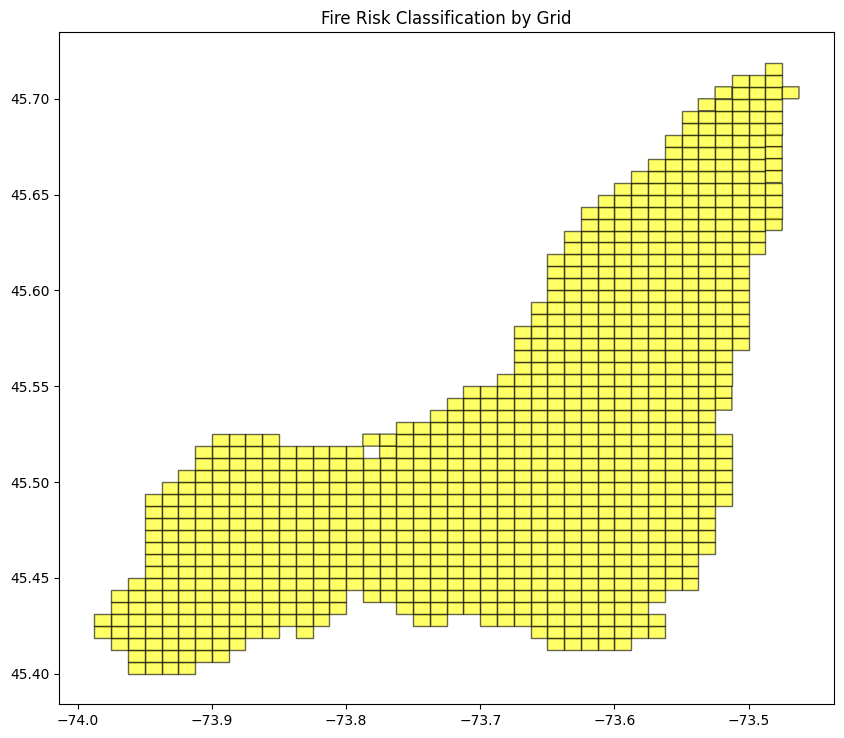

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

INCIDENTS_FILE_PATH = "/content/incidents-clean.csv"
GRID_FILE_PATH = "/content/sqrc_1000 (1).geojson"

df_fires = pd.read_csv(INCIDENTS_FILE_PATH)

df_fires.columns = df_fires.columns.str.upper()

df_fires = df_fires.dropna(subset=["LATITUDE", "LONGITUDE"])

fire_type_weights = {"Building Fire": 3, "Vehicle Fire": 2, "Trash Fire": 1}
df_fires["SEVERITY_SCORE"] = df_fires["DESC_GROUP_ENGLISH"].map(fire_type_weights) * df_fires["NOMBRE_UNITES"]

# Convert fire dataset into a GeoDataFrame
df_fires["geometry"] = df_fires.apply(lambda row: Point(row["LONGITUDE"], row["LATITUDE"]), axis=1)
df_fires_gdf = gpd.GeoDataFrame(df_fires, geometry="geometry", crs="EPSG:4326")

# Load the 1 km grid (GeoJSON)
grid_gdf = gpd.read_file(GRID_FILE_PATH)

# Ensure correct CRS for the grid
if grid_gdf.crs is None:
    print("\n🚨 Warning: No CRS detected in Grid! Setting to EPSG:4326...")
    grid_gdf = grid_gdf.set_crs("EPSG:4326")

# Perform spatial join to assign fires to grid squares
fires_with_grid = gpd.sjoin(df_fires_gdf, grid_gdf, how="left", predicate="intersects")

# Count fire incidents per grid cell
grid_gdf["fire_count"] = fires_with_grid.groupby("index_right").size()
grid_gdf["fire_count"] = grid_gdf["fire_count"].fillna(0)  # Avoid inplace warning

# Aggregate severity score per grid
severity_per_grid = fires_with_grid.groupby("index_right")["SEVERITY_SCORE"].sum()
grid_gdf["severity_score"] = severity_per_grid.fillna(0)

# Normalize Scores (0-100 scale)
grid_gdf["fire_count_norm"] = (grid_gdf["fire_count"] - grid_gdf["fire_count"].min()) / (grid_gdf["fire_count"].max() - grid_gdf["fire_count"].min()) * 100
grid_gdf["severity_score_norm"] = (grid_gdf["severity_score"] - grid_gdf["severity_score"].min()) / (grid_gdf["severity_score"].max() - grid_gdf["severity_score"].min()) * 100

#  Combined Score (50% Fire Count, 50% Severity)
grid_gdf["combined_score"] = 0.5 * grid_gdf["fire_count_norm"] + 0.5 * grid_gdf["severity_score_norm"]

# Categorize Risk Levels
high_threshold = grid_gdf["combined_score"].quantile(0.8)
low_threshold = grid_gdf["combined_score"].quantile(0.2)

grid_gdf["risk_category"] = "Medium"
grid_gdf.loc[grid_gdf["combined_score"] >= high_threshold, "risk_category"] = "High"
grid_gdf.loc[grid_gdf["combined_score"] <= low_threshold, "risk_category"] = "Low"

# Define colors for risk levels
risk_colors = {"High": "red", "Medium": "yellow", "Low": "green"}
grid_gdf["color"] = grid_gdf["risk_category"].map(risk_colors)

# Plot the risk map
fig, ax = plt.subplots(figsize=(10, 10))
grid_gdf.plot(ax=ax, color=grid_gdf["color"], edgecolor="black", alpha=0.6)
plt.title("Fire Risk Classification by Grid")
plt.show()


In [ ]:
print(grid_gdf["combined_score"].describe())


count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: combined_score, dtype: float64


In [ ]:
print(grid_gdf[["fire_count", "severity_score"]].describe())


       fire_count  severity_score
count  895.000000           794.0
mean   104.782123             0.0
std    132.257150             0.0
min      0.000000             0.0
25%     17.500000             0.0
50%     60.000000             0.0
75%    146.500000             0.0
max    958.000000             0.0


In [ ]:
fire_type_weights = {"Building Fire": 3, "Vehicle Fire": 2, "Trash Fire": 1}
df_fires["SEVERITY_SCORE"] = df_fires["DESC_GROUP_ENGLISH"].map(fire_type_weights) * df_fires["NOMBRE_UNITES"]


In [ ]:
print(df_fires["DESC_GROUP_ENGLISH"].unique())


['Other fires' 'Building fire']


In [ ]:
# Convert column names and values to uppercase for consistency
df_fires["DESC_GROUP_ENGLISH"] = df_fires["DESC_GROUP_ENGLISH"].str.upper()

# Updated fire type weights to match dataset
fire_type_weights = {
    "BUILDING FIRE": 3,  # Keep high severity for buildings
    "OTHER FIRES": 1  # Assign lowest severity to "Other fires"
}

# Apply mapping
df_fires["SEVERITY_SCORE"] = df_fires["DESC_GROUP_ENGLISH"].map(fire_type_weights) * df_fires["NOMBRE_UNITES"]

# Fill NaN values with 0
df_fires["SEVERITY_SCORE"].fillna(0, inplace=True)


<ipython-input-52-ce953aead5a6>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_fires["SEVERITY_SCORE"].fillna(0, inplace=True)


In [ ]:
print(df_fires[["DESC_GROUP_ENGLISH", "SEVERITY_SCORE"]].head(10))


  DESC_GROUP_ENGLISH  SEVERITY_SCORE
0        OTHER FIRES             4.0
1        OTHER FIRES             1.0
2        OTHER FIRES             4.0
3      BUILDING FIRE            21.0
4      BUILDING FIRE            24.0
5      BUILDING FIRE             9.0
6        OTHER FIRES             1.0
7        OTHER FIRES             1.0
8      BUILDING FIRE             9.0
9        OTHER FIRES             3.0


In [ ]:
# Ensure NaNs are replaced with 0 before normalization
grid_gdf["fire_count"] = grid_gdf["fire_count"].fillna(0)
grid_gdf["severity_score"] = grid_gdf["severity_score"].fillna(0)

# Normalize Scores (0-100 scale)
grid_gdf["fire_count_norm"] = (grid_gdf["fire_count"] - grid_gdf["fire_count"].min()) / (grid_gdf["fire_count"].max() - grid_gdf["fire_count"].min()) * 100
grid_gdf["severity_score_norm"] = (grid_gdf["severity_score"] - grid_gdf["severity_score"].min()) / (grid_gdf["severity_score"].max() - grid_gdf["severity_score"].min()) * 100

# Handle cases where min == max (avoid division by zero)
grid_gdf["fire_count_norm"].fillna(0, inplace=True)
grid_gdf["severity_score_norm"].fillna(0, inplace=True)

# Compute the final risk score (weighted 50% fire count, 50% severity)
grid_gdf["combined_score"] = 0.5 * grid_gdf["fire_count_norm"] + 0.5 * grid_gdf["severity_score_norm"]


<ipython-input-54-8d9538154492>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  grid_gdf["fire_count_norm"].fillna(0, inplace=True)
<ipython-input-54-8d9538154492>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [ ]:
# Adjust thresholds for categorization
high_threshold = grid_gdf["combined_score"].quantile(0.75)  # Top 25% = High Risk
low_threshold = grid_gdf["combined_score"].quantile(0.25)   # Bottom 25% = Low Risk

# Assign categories
grid_gdf["risk_category"] = "Medium"
grid_gdf.loc[grid_gdf["combined_score"] >= high_threshold, "risk_category"] = "High"
grid_gdf.loc[grid_gdf["combined_score"] <= low_threshold, "risk_category"] = "Low"


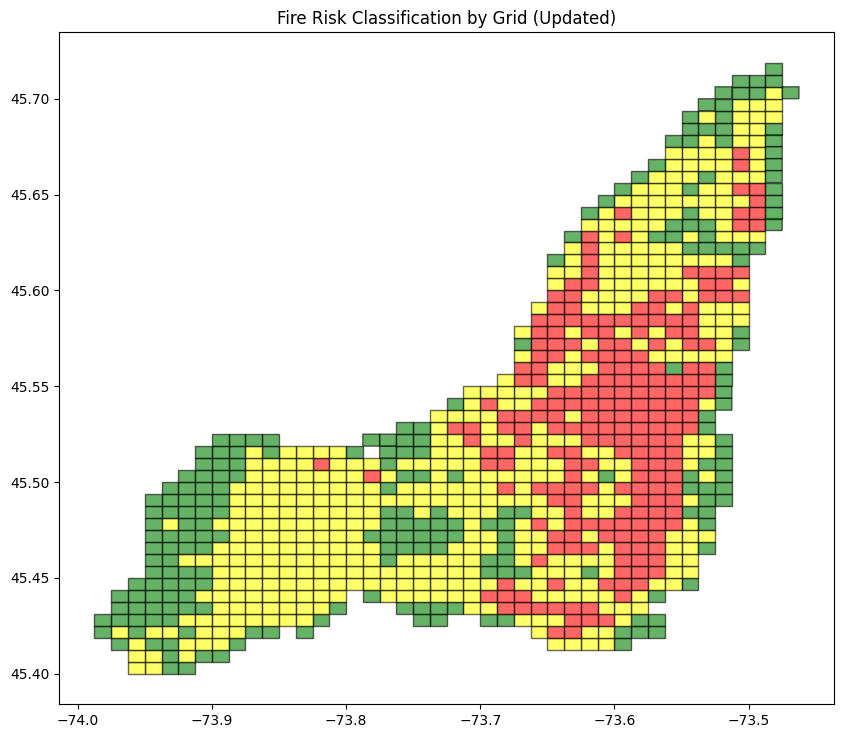

In [ ]:
import matplotlib.pyplot as plt

#  Define colors for risk levels
risk_colors = {"High": "red", "Medium": "yellow", "Low": "green"}
grid_gdf["color"] = grid_gdf["risk_category"].map(risk_colors)

# Plot the updated risk map
fig, ax = plt.subplots(figsize=(10, 10))
grid_gdf.plot(ax=ax, color=grid_gdf["color"], edgecolor="black", alpha=0.6)
plt.title("Fire Risk Classification by Grid (Updated)")
plt.show()


In [ ]:
# Compute quantile-based thresholds for 4 risk levels
high_threshold = grid_gdf["combined_score"].quantile(0.85)  # Top 15%
moderate_high_threshold = grid_gdf["combined_score"].quantile(0.50)  # Top 50%
moderate_low_threshold = grid_gdf["combined_score"].quantile(0.15)  # Bottom 50%

# Assign categories
grid_gdf["risk_category"] = "Moderate-Low"
grid_gdf.loc[grid_gdf["combined_score"] >= moderate_high_threshold, "risk_category"] = "Moderate-High"
grid_gdf.loc[grid_gdf["combined_score"] >= high_threshold, "risk_category"] = "High"
grid_gdf.loc[grid_gdf["combined_score"] <= moderate_low_threshold, "risk_category"] = "Low"


In [ ]:
# Define colors for 4 risk levels
risk_colors = {
    "High": "red",
    "Moderate-High": "orange",
    "Moderate-Low": "yellow",
    "Low": "green"
}

grid_gdf["color"] = grid_gdf["risk_category"].map(risk_colors)


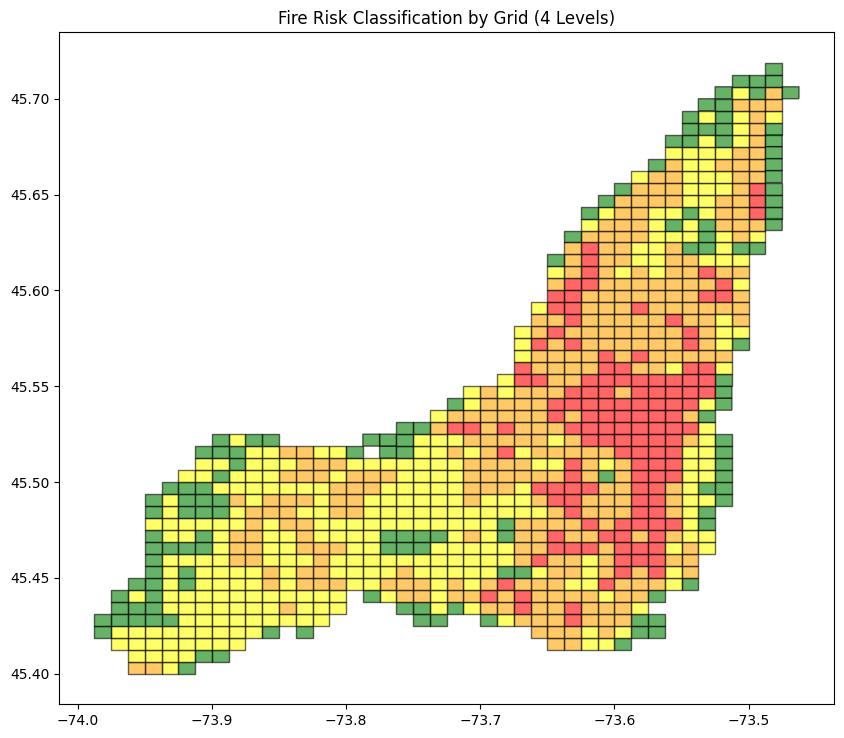

In [ ]:
import matplotlib.pyplot as plt

# Plot with 4 risk categories
fig, ax = plt.subplots(figsize=(10, 10))
grid_gdf.plot(ax=ax, color=grid_gdf["color"], edgecolor="black", alpha=0.6)
plt.title("Fire Risk Classification by Grid (4 Levels)")
plt.show()


In [ ]:
import folium
import geopandas as gpd
import json
from shapely.geometry import mapping

#  Define the center of the map (adjust to your city's coordinates)
montreal_center = [45.5, -73.6]  # Adjust as needed

# Create a Folium map centered on Montreal
m = folium.Map(location=montreal_center, zoom_start=11, tiles="cartodbpositron")  # Use a clean basemap

#  Convert the GeoDataFrame to GeoJSON for overlay
grid_gdf_json = json.loads(grid_gdf.to_json())

#  Define a color mapping function based on the risk category
def style_function(feature):
    risk_category = feature["properties"]["risk_category"]
    color_map = {
        "High": "red",
        "Moderate-High": "orange",
        "Moderate-Low": "yellow",
        "Low": "green"
    }
    return {
        "fillColor": color_map[risk_category],
        "color": "black",
        "weight": 0.5,
        "fillOpacity": 0.5
    }

#  Add the GeoJSON layer to the map
folium.GeoJson(
    grid_gdf_json,
    name="Fire Risk Grid",
    style_function=style_function
).add_to(m)

# Add a Layer Control
folium.LayerControl().add_to(m)

#  Show the map
m.save("fire_risk_map.html")
m


In [ ]:
pip install selenium pillow folium geopandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.3/486.3 kB 33.4 MB/s eta 0:00:00


In [ ]:
!apt-get update
!apt-get install -y chromium-chromedriver


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,309 kB]
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [66.7 kB]
Get:13 https://r2u.stat.illinois.e

In [ ]:
import time
import folium
import json
import geopandas as gpd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from PIL import Image

#
montreal_center = [45.5, -73.6]

#  Create a Folium map
m = folium.Map(location=montreal_center, zoom_start=11, tiles="cartodbpositron")

#  Convert the GeoDataFrame to GeoJSON
grid_gdf_json = json.loads(grid_gdf.to_json())

#  Define a color mapping function
def style_function(feature):
    risk_category = feature["properties"]["risk_category"]
    color_map = {
        "High": "red",
        "Moderate-High": "orange",
        "Moderate-Low": "yellow",
        "Low": "green"
    }
    return {
        "fillColor": color_map[risk_category],
        "color": "black",
        "weight": 0.5,
        "fillOpacity": 0.5
    }

#  Add the GeoJSON layer to the map
folium.GeoJson(grid_gdf_json, name="Fire Risk Grid", style_function=style_function).add_to(m)

#  Save map as HTML
html_map_path = "fire_risk_map.html"
m.save(html_map_path)

#  Set up Selenium to open the HTML file
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--window-size=1200x900")

driver = webdriver.Chrome(options=chrome_options)
driver.get("file://" + html_map_path)

#  Wait for the map to fully load
time.sleep(3)

#  Save screenshot
screenshot_path = "fire_risk_map.png"
driver.save_screenshot(screenshot_path)
driver.quit()

#  Convert PNG to JPEG
image = Image.open(screenshot_path)
jpeg_path = "fire_risk_map.jpg"
image.convert("RGB").save(jpeg_path, "JPEG")

print(f" Map saved as: {jpeg_path}")


SessionNotCreatedException: Message: session not created: probably user data directory is already in use, please specify a unique value for --user-data-dir argument, or don't use --user-data-dir
Stacktrace:
#0 0x5bd4cf4dc09a <unknown>
#1 0x5bd4cefa38b0 <unknown>
#2 0x5bd4cefdcea4 <unknown>
#3 0x5bd4cefd88ff <unknown>
#4 0x5bd4cf02929f <unknown>
#5 0x5bd4cf0287d6 <unknown>
#6 0x5bd4cf01a753 <unknown>
#7 0x5bd4cefe638e <unknown>
#8 0x5bd4cefe7b51 <unknown>
#9 0x5bd4cf4a576b <unknown>
#10 0x5bd4cf4a96f2 <unknown>
#11 0x5bd4cf4918fc <unknown>
#12 0x5bd4cf4aa2e4 <unknown>
#13 0x5bd4cf4759cf <unknown>
#14 0x5bd4cf4cacd8 <unknown>
#15 0x5bd4cf4caeb6 <unknown>
#16 0x5bd4cf4daf16 <unknown>
#17 0x7f66b0073ac3 <unknown>


In [ ]:
import geopandas as gpd
import folium
import json
import random

#  Load the Grid (1 km Squares)
grid_file = "/content/sqrc_1000 (1).geojson"
grid_gdf = gpd.read_file(grid_file)

#  Load the Borough Boundaries
boroughs_file = "/content/limites-administratives-agglomeration-nad83.geojson"
boroughs_gdf = gpd.read_file(boroughs_file)

#  Ensure both datasets use the same CRS (EPSG:4326)
if grid_gdf.crs is None:
    grid_gdf = grid_gdf.set_crs(epsg=4326)
else:
    grid_gdf = grid_gdf.to_crs(epsg=4326)

if boroughs_gdf.crs is None:
    boroughs_gdf = boroughs_gdf.set_crs(epsg=4326)
else:
    boroughs_gdf = boroughs_gdf.to_crs(epsg=4326)

#  Perform a spatial join to assign each grid square to a borough
grid_with_boroughs = gpd.sjoin(grid_gdf, boroughs_gdf, how="left", predicate="intersects")

#  Check if the join worked (print a sample)
print(grid_with_boroughs[["NOM", "geometry"]].head())

#  Generate distinct colors for each borough
boroughs = grid_with_boroughs["NOM"].dropna().unique()  # Remove NaN values
color_map = {borough: "#{:06x}".format(random.randint(0, 0xFFFFFF)) for borough in boroughs}

#  Define a style function for the grid
def style_function(feature):
    borough_name = feature["properties"].get("NOM", "Unknown")  # Get borough name
    return {
        "fillColor": color_map.get(borough_name, "#CCCCCC"),  # Default gray if no borough
        "color": "black",
        "weight": 0.6,  # Ensure grid squares are outlined properly
        "fillOpacity": 0.7  # Increase visibility
    }

#  Create the Folium Map
montreal_center = [45.5, -73.6]
m = folium.Map(location=montreal_center, zoom_start=11, tiles="cartodbpositron")

#  Convert the grid with boroughs to GeoJSON and add to map
# Convert Timestamp columns to string before converting to JSON
for col in grid_with_boroughs.select_dtypes(include=["datetime64"]).columns:
    grid_with_boroughs[col] = grid_with_boroughs[col].astype(str)

#  Now safely convert to JSON
grid_geojson = json.loads(grid_with_boroughs.to_json())

folium.GeoJson(
    grid_geojson,
    name="Grid with Boroughs",
    style_function=style_function
).add_to(m)

#  Add a legend
legend_html = '''
<div style="position: fixed;
            bottom: 20px; left: 20px; width: 250px; height: auto;
            background-color: white; z-index:9999; font-size:14px;
            padding: 10px; border-radius: 5px;">
<b>Boroughs</b><br>
''' + "".join([f'<div style="display:inline-block;width:12px;height:12px;background-color:{color_map[b]};margin-right:5px;"></div>{b}<br>' for b in boroughs]) + "</div>"

m.get_root().html.add_child(folium.Element(legend_html))

#  Save and display the map
m.save("borough_grid_map.html")
m


                                        NOM  \
0  Rivière-des-Prairies-Pointe-aux-Trembles   
1  Rivière-des-Prairies-Pointe-aux-Trembles   
2  Rivière-des-Prairies-Pointe-aux-Trembles   
3  Rivière-des-Prairies-Pointe-aux-Trembles   
4  Rivière-des-Prairies-Pointe-aux-Trembles   

                                            geometry  
0  POLYGON ((-73.5 45.65, -73.5 45.65333, -73.5 4...  
1  POLYGON ((-73.5 45.65625, -73.5 45.65667, -73....  
2  POLYGON ((-73.5 45.6625, -73.5 45.66833, -73.5...  
3  POLYGON ((-73.5 45.66875, -73.5 45.675, -73.50...  
4  POLYGON ((-73.5 45.675, -73.5 45.68125, -73.50...  
